<h2>Fire Alerts Via GOES-R Fire Detection Algorithm</h2>

The <b>GOES-17</b> satellite became operational in February 2019. One of the main functions of the satellite is fire track
and intensity information.<br>
The <b>purpose of this program</b> is to alert users to hotspots detected by the GOES-R satellite. The alert is 
designed to include an mp4 of a Fire/True-Color composite image from the GOES-R data.
<div align="left">
<video src="fire_cur.mp4" type="video/mp4" width="30%" controls></video></div>
 
 Additional information on the GOES-R hotspot detection algorithm can be found from: 
 
 [GOES-R Hotspot Detection](https://www.goes-r.gov/products/baseline-fire-hot-spot.html)
 
 This program accomplishes this in three main steps:
 
 1) Analyze the GOES-16/17 hotspot characterization netCDF files from the AWS S3 bucket.
 <br>2) For each file, if a hotspot is found:
    <ul><li> Determine if it meets various criteria (e.g. proximity from user).
    </li><li>Test if the hotspot is part of a larger complex of hotspots.
    </li><li> Assign the hotspot an ID for future reference.  
     </li></ul>
  3) Alert the end user given various criteria (e.g. the hotspot is new). 
 
 
Breaking this down a bit further yields: <br>
<ol>
    <li> Temporarily download the necessary GOES-16/17 netCDF via AWS s3 bucket.</li>
    <li> Analise the netCDF raster for points in band 7 (red) that are greater than 329K (133F). </li>
    <li> If any points are > 329K:<ul>
            <li> Group points of the same fire together (this is based on distance of each point from another). </li>
            <li> Determine if the fire group has already been designated as an "active fire" by CalFire.
               <br> i) If so, ID this point with the CalFire indident ID.
                <br>ii) if not, give it an arbitrary ID.
            </li>
            <li> Store the lat/lng, fire ID, and time of scan into the database.</li>
        </ul>
     </li>
     <li>If active fire points were found, create an image for that scan and save it in the database.</li>
     <h4> Note: Step 4 (image creation) is where most of the heavy lifting is done. </h4>
        <br><b>Additional Work Needed<br></b>5) TODO: Alert user that a new fire has been found based on user's preferences (e.g. proximity to fire)
            a) Send text / email with:
                i) Link to CalFire's incident page for the fire (contained in csv that is downloaded)
                ii) gif loop of the last 2 hours of data from the GOES satellite.
                iii) Fire info relative to user (distance to fire, fire spread rate, etc)
        TODO: Future: Determine frequency of scans based on fire risk, where fire risk is based on SPC fire outlook,
                      redflag warnings, fire watches, or model output (e.g. wind gusts / low humidity).


In [355]:
from osgeo.gdalnumeric import *
from pyproj import Proj, Geod, transform
from functools import partial
from datetime import datetime, timedelta
import sqlite3
import os, io, time
import pandas as pd
import boto3
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import imageio
from PIL import Image
import shapely, shapely.ops
from shapely.geometry import Point, MultiPoint
import json
import logging
from GOES_Image_Creator import Fire_Image
from noaa_aws import AwsGOES
from timeloop import Timeloop
import mailer


In [356]:
## Setup Connection to Database.
DB_PATH = 'db_jupyter.sqlite3'
CONN = sqlite3.connect(DB_PATH, check_same_thread=False)
CURSOR = CONN.cursor()


A total of 4 tables were created in the database. 
<ol>
<li><b> cal_fire:</b> This table is simply used to store the fire incident information from Cal Fire. 
               The data in the table are replaced with each pull from Cal Fire's website.</li>
<li><b>fdfc_files_downloaded:</b> The idea here was to have a table to stores information about which
files on the S3 bucket have already been examined. Basically, we don't want to download the data twice. 
Also, since the GOES multiband files (used for image creation) and FDFC files (aka fire hotspot files) 
are two seperate files, we need to ensure that each of the files are assoicated with similar scan times. 
In other words, we don't want to create an image from a GOES multiband scan taken at 12:30Z that is assocated with
a GOES hotspot detection file from 06:45Z. Thus, this table will contain colums that tell us for a given
FDFC file, what is the GOES multiband file that occured closest in time. 
</li>
<li><b>goes_r_fire:</b> This table will store location information for every pixel determined to
                        be an active fire by the GOES hotspot detection algorithm.   
</li>
<li><b>goes_r_images:</b> Contains images created by matplotlib / cartopy. This could contain 
                          an image for every single scan, but for now, it's only used to hold 
                          the image needed to create an mp4 video. 
</li>
<li><b>user_alert_log:</b> This table provides a way to ensure that a user is alerted only once
                            to any new fire. 
</li>
<li><b>users:</b> User data. 
</ol>
The code to create each table is as follows:  

In [357]:
def create_calfire_table():
    db_path = os.path.join(os.path.dirname(__file__), 'db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS cal_fire("
            "incident_id TEXT PRIMARY KEY,"
            "id INTEGER,"
            "incident_name TEXT,"
            "incident_is_final INTEGER,"
            "incident_date_last_update DATETIME,"
            "incident_date_created DATETIME,"
            "incident_administrative_unit TEXT,"
            "incident_administrative_unit_url TEXT,"
            "incident_county TEXT,"
            "incident_location TEXT,"
            "incident_acres_burned INTEGER,"
            "incident_containment INTEGER,"
            "incident_control TEXT,"
            "incident_cooperating_agencies TEXT,"
            "incident_longitude FLOAT,"
            "incident_latitude FLOAT,"
            "incident_type TEXT,"
            "incident_url TEXT,"
            "incident_date_extinguished DATETIME,"
            "incident_dateonly_extinguished DATETIME,"
            "incident_dateonly_created DATETIME,"
            "is_active INTEGER)")




def create_goes_r_fire_table():
    db_path = os.path.join('db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS goes_r_fire("
              "id INTEGER,"
              "cal_fire_incident_id TEXT,"
              "lat FLOAT,"
              "lng FLOAT,"
              "scan_dt DATETIME,"
              "s3_filename TEXT,"
              "fire_id INTEGER, "
              "UNIQUE(lat, lng, scan_dt) ON CONFLICT REPLACE, "
              "FOREIGN KEY (cal_fire_incident_id) REFERENCES cal_fire(incident_id),"
              "FOREIGN KEY (scan_dt) REFERENCES goes_r_images(scan_dt))")

def create_goes_r_image_table():
    db_path = os.path.join('db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS goes_r_images("
              "id INTEGER,"
              "scan_dt DATETIME,"
              "fire_temp_image BLOB,"
              "fire_temp_gif BLOB, "
              "s3_filename TEXT,"
              "FOREIGN KEY (scan_dt) REFERENCES goes_r_images(scan_dt))")


def create_user_table():
    db_path = os.path.join('db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS users("
              "id INTEGER,"
              "user_id TEXT,"
              "first_name TEXT,"
              "last_name TEXT,"
              "email TEXT, "
              "alert_time_start DATETIME, "
              "alert_time_end DATETIME, "
              "user_lat FLOAT,"
              "user_lng FLOAT,"
              "fav_lat FLOAT,"
              "fav_lng FLOAT,"
              "last_alert DATETIME,"
              "alerted_calfire_id TEXT,"
              "UNIQUE(user_id, email) ON CONFLICT REPLACE)")

def create_user_alert_table():
    db_path = os.path.join('db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS user_alert_log("
              "id INTEGER,"
              "user_id TEXT,"
              "alerted_cal_fire_incident_id TEXT,"
              "alerted_incident_id TEXT,"
              "alert_time DATETIME,"
              "need_to_alert INTEGER,"
              "dist_to_fire FLOAT,"
              "fire_lat FLOAT,"
              "fire_lng FLOAT,"
              "FOREIGN KEY (user_id) REFERENCES users(user_id))")

def create_downloaded_files_table():
    db_path = os.path.join('db_jupyter.sqlite3')
    conn = sqlite3.connect(db_path)
    c = conn.cursor()
    c.execute("CREATE TABLE IF NOT EXISTS fdfc_files_downloaded("
              "id INTEGER," 
              "s3_filename_fdfc TEXT,"
              "s3_filename_multiband TEXT,"
              "new_fires INTEGER,"
              " DATETIME)")
    

<b> If needed, uncomment any of the code below to create the various tables

In [358]:
#create_calfire_table()
#create_goes_r_fire_table()
#create_goes_r_image_table()
#create_user_table()
#create_user_alert_table()
#create_downloaded_files_table()


Create some dummy data for a user if needed. 

In [359]:
# sql = '''INSERT INTO users 
# (user_id, user_lat, user_lng) 
# VALUES (1, 38.5, -109.5)'''
# CURSOR.execute(sql)
# CONN.commit()


 <b>Now that the initial databases are set up we can proceed:


In [360]:
## Setup Connection to Database.
DB_PATH = 'db_jupyter.sqlite3'
CONN = sqlite3.connect(DB_PATH, check_same_thread=False)
CURSOR = CONN.cursor()


# Search the S3 bucket for the first scan that occurred closest to the following time
#first_scan = datetime.utcnow().strftime("%m/%d/%Y %H:%M")
first_scan = datetime.utcnow().strftime("07/29/2019 23:00")

# The number of hours to search for files after "first_scan. If set to zero, this will get the latest scan.
hours_of_data = 1

# The noaa AWS resource is in an S3 bucket called 'noaa-goes##'
s3 = boto3.resource('s3')
bucket = 'noaa-goes17'

# Object for the GOES fire detection files (i.e. FDCF) in the S3 bucket
goes_hotspot = AwsGOES(
                bands=['FDCF'],
                bucket=bucket,
                st_dt=first_scan,
                hrs=hours_of_data)

# Object for the GOES multiband files in the S3 bucket
goes_multiband = AwsGOES(
                bands=[7,8],
                bucket=bucket,
                st_dt=first_scan,
                hrs=hours_of_data)

goes_multiband_files = goes_multiband.bucket_files


The GOES-R produces multiple products that are placed in the in the AWS bucket. 
[List Of Various Goes Products](https://www.goes-r.gov/products/baseline.html)


Not all the files are produced at the same time (or at all). For example, files for the Multiband 
product are typically produced every ~5 minutes whereas the Fire Hotspot detection files 
(aka FDFC files) are produced every 10 minutes.

For a given scan, we want to the files are that closest in time to one another. This method will return a
dict of key/value pairs where:
    
   Key: Multiband filename and the value is the...<br>
   Value: Hotspot detection filename whose creation date is closest in time to the Multiband file.


In [361]:
def find_closest_file(multiband_files, hotspot_files):
    """
    The GOES-R produces multiple products that are placed in the in the AWS bucket. Not all the files are produced
    at the same time (or at all). For example, files for the Multiband product are typically produced
    every ~5 minutes whereas the Fire Hotspot detection files (aka FDFC files) are produced every 10 minutes.

    For a given scan, we want to the files are that closest in time to one another. This method will return a
    dict of key/value pairs where:

    Key: Multiband filename and the value is the...
    Value: Hotspot detection filename whose creation date is closest in time to the Multiband file.

    :param multiband_files: The file names of the Multiband files in the S3 bucket
    :param hotspot_files: The files names of the hotspot detection files in the s3 bucket.
    :return: Dict of key/value pairs where
    Key: Multiband filename and the value is the
    Value: Hotspot detection filename whose creation date is closest in time to the Multiband file.
    """

    # Holder for file key/value pair dict.
    file_combo = {}

    # The naming convention of the files includes the timestamp in the filenames.
    # There are three timestamps in the file name: The '_c' is the "center" between the start and end time.
    # This will return a dict with a KEY: file path in the S3 bucket of the FDCF file and VALUE: the datetime of the scan.
    hotspot_file_times = {fname: datetime.strptime((fname.split("_c")[1]).replace('.nc',""),"%Y%j%H%M%S%f")
                          for fname in hotspot_files}


    for mb in multiband_files:
        # The naming convention of the files includes the timestamp in the filenames.
        # There are three timestamps in the file name: The '_c' is the "center" between the start and end time.
        mb_time = datetime.strptime((mb.split("_c")[1]).replace('.nc',""),"%Y%j%H%M%S%f")

        # Returns the time of the hotspot file that is closest in time to the mb_time.
        closest_hotspot_time = min(hotspot_file_times.values(), key=lambda t: abs(t-mb_time))

        # From the list of FDCF filepaths, return the file path for the given time.
        closest_hotspot_file = list(hotspot_file_times.keys())[list(hotspot_file_times.values()).index(closest_hotspot_time)]

        timedelta = abs(closest_hotspot_time - mb_time)

        # Append to dictionary
        file_combo[mb] = closest_hotspot_file
    return file_combo


In [362]:
# ALL_FILES contains a dict of key/values where the key is the multiband file and the value is the
# most recent FDFC file to that particular multiband scan.
ALL_FILES = find_closest_file(goes_multiband_files,goes_hotspot.bucket_files)

CURSOR.execute("SELECT s3_filename_multiband FROM fdfc_files_downloaded")
already_examined = [item[0] for item in list(CURSOR.fetchall())]
print(list(ALL_FILES.keys())[-1])


ABI-L2-MCMIPC/2019/210/23/OR_ABI-L2-MCMIPC-M6_G17_s20192102356197_e20192102358575_c20192102359093.nc


<style type="text/css">
 .tab { margin-left: 40px; }
</style>
We are now at the point where we have a list of all the files available in the s3 bucket from 
the past hour for <b> both </b> the multiband files and FDFC files. Now, the program needs to 
temporarily download any files that haven't been examined yet. 
<br><br><b>
In the actual program, this is performed with a <code>for</code> loop as shown below.
</b>
<br>
Since <code>ALL_FILES</code> is a dict where:
<p class="tab">
<code>key</code>=multiband file path for a given time. <br>
<code>value</code>=Hotspot detection file path for a the file scan occurring closest in time to the multiband file.
</p>
Since the jupyter notebook can't loop outside of each scope, 
we can just use <code>list(ALL_FILES.keys())[-1] </code> to reduce the sice of the array to use the most recent file


In [363]:
# If you wanted to loop through every file, you would use the code in the next line below
#for FILE in (FILE for FILE in ALL_FILES.keys() if FILE not in already_examined):
# Get Lat/lng values of all active fire points via GOES-R FIRE/HOTSPOT Characterization:
#C = goes_hotspot.download_file(ALL_FILES[FILE], goes_hotspot.bucket, s3)  # HOT SPOT DOWNLOAD

# Get Lat/lng values of all active fire points via GOES-R FIRE/HOTSPOT Characterization:
FILE = ALL_FILES[list(ALL_FILES.keys())[-1]]
C = goes_hotspot.download_file(FILE, goes_hotspot.bucket, s3)  # HOT SPOT DOWNLOAD

# Timestamp on Fire Characterization / Hotspot detection file.
fdfc_seconds = int(np.ma.round(C.variables['t'][0], decimals=0))

# Times reported in seconds since 2000-01-01 12:00:00
fdfc_DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=fdfc_seconds)

 # Load the RGB arrays for muti-band data
FM = C.variables['Mask'][:].data  # Fire Mask
FM = FM.astype(np.float64)

Download Successful C:\Users\smotley\AppData\Local\Temp\tmpum_joxuj


<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>

   Excerpt from: https://www.ncdc.noaa.gov/sites/default/files/attachments/ABI_L2_FHS_Provisional_ReadMe_0.pdf
    
   *** Operational  users  who  have  the  lowest  tolerance  for  false  alarms should use the “processed”
   and “saturated” categories (mask codes 10, 11, 30, and 31 marked in <font color='red'>red</font>), but understand there can still be false alarms. 
   From the data I have processed, each pixel can only have ONE code. For example, a fire pixel is either 10 or 30, but 
   not both. So when we get to our raster data, you'll see we have to check for both of these codes. 
    
   <table> 
   <tr>
        <th>Mask Codes</th>
        <th>Description</th>
    </tr>
   <tr>
        <td> -99 </td> 
        <td>Initialization value, should never appear in outputs</td>
   </tr>
   <tr>
    <td>0</td>      
        <td>Non-processed region of input/output image</td></tr>
   <tr>
    <td><b>10</td></b>   
            <td><b>Processed fire pixel (codes 10 and 30):<br><font color='red'>The highest fire confidence category</font>, includes  FRP, 
                size, and temperature estimates.</td></tr></b>
       
   <tr>             
    <td><b>11</td>    <td><b>Saturated fire pixel (codes 11 and 31): <br><font color='red'>Very high confidence</font> fires, but the pixel was at 
                                                                instrument saturation so no properties could be 
                                                                determined. 
                                                                </td></tr>
    <tr>                                                            
    <td>12</td>    <td>Cloud contaminated fire pixel (codes 12 and 32): <br>   A moderate confidence fire that appears to be 
                                                                partially obscured by cloud; intended for users with 
                                                                a high tolerance for false alarms.
                                                                </td></tr>
    <tr>                                                            
    <td>13</td>    <td>High probability fire pixel (codes 13 and 33):<br>      A possible fire with a lower thermal signature than 
                                                                needed to be deemed a Processed fire pixel; 
                                                                FRP is calculated for these pixels; intended for 
                                                                userswith a high tolerance for false alarms; 
                                                                false alarms due to water clouds 
                                                                are common in this category.</tr>
    <tr>                                                            
    <td>14</td>    <td>Medium probability fire pixel  (codes 14 and 34):<br>   A medium confidence firewith a lower thermal 
                                                                signature than a High probability fire pixel would 
                                                                have for this pixel; intended for users with a high 
                                                                tolerance  for  false  alarms;  false  alarms  due  
                                                                to  water  clouds are  common  in  this category.</tr>
    <tr>
    <td>15</td>    <td>Low probability fire pixel (codes 15 and 35):<br>       Lowest confidence fire class, a large number of 
                                                                false alarms are to be expected, it is included 
                                                                as it also contains small and/or cooler fires; 
                                                                intended for users  with  a  high  tolerance  for  
                                                                false  alarms;  false  alarms  due  to  water  
                                                                clouds are common in this category.</tr>
   <tr><td>20</td>    <td>Reserved</tr>
    <tr><td>21</td>    <td>Reserved</tr>
    <tr><td>22</td>    <td>Reserved</tr>
    <tr><td>23</td>    <td>Reserved</tr>
    <tr><td>24</td>   <td>Reserved</tr>
    <tr><td>25</td>    <td>Reserved</tr>
    <tr><td><b>30</td>    <td><font color='red'><b>Temporally Filtered Processed fire pixel</tr></font>
    <tr><td><b>31</td>    <td><font color='red'><b>Temporally Filtered Saturated fire pixel</tr></font>
    <tr><td>32</td>    <td>Temporally Filtered Cloud contaminated fire pixel</tr>
    <tr><td>33</td>    <td>Temporally Filtered High probability fire pixel</tr>
    <tr> <td>34</td>    <td>Temporally Filtered Medium probability fire pixel</tr>
    <tr><td>35</td>    <td>Temporally Filtered Low probability fire pixel</tr>
    <tr><td>40</td>    <td>Space pixel</tr>
    <tr><td>50</td>    <td>Localzenith angle block-out zone, greater than threshold of 80°</tr>
    <tr><td>60</td>    <td>Reflectance(glint)angle  or  solar  zenith  angle  block-out  zone, within  respective thresholds, 10° and 10° respectively</tr>
    <tr><td>100</td>   <td>Processed region of image</tr>
    <tr><td>120</td>   <td>Bad input data: missing data, 3.9 μm (Channel7)</tr>
    <tr><td>121</td>   <td>Bad input data: missing  data, 11.2 μm ( Channel14)</tr>
    <tr><td>123</td>   <td>Bad input data: saturation, 3.9 μm ( Channel7)</tr>
    <tr><td>124</td>   <td>Bad input data: saturation, 11.2 μm ( Channel14)</tr>
    <tr><td>125</td>   <td>Invalid  reflectivity  product  input(value  <0). Can  be  indicative  of  localized  spikes in the reflectivity product/bad data</tr>
    <tr><td>126</td>   <td>Unusable input data: 3.9 μm ( Channel7)less than minimum threshold (200 K)</tr>
    <tr><td>127</td>   <td>Unusable input data: 11.2μm ( Channel14)less than minimum threshold (200 K)</tr>
    <tr><td>130</td>   <td>Reserved</tr>
    <tr><td>150</td>   <td>Invalid ecosystem type</tr>
    <tr><td>151</td>   <td>Sea water</tr>
    <tr><td>152</td>   <td>Coastline Fringe</tr>
    <tr><td>153</td>   <td>Inland Water and other Land/water mix</tr>
    <tr><td>155</td>   <td>Reserved</tr>
    <tr><td>160</td>   <td>Invalid emissivity value</tr>
    <tr><td>170 </td>  <td>No background value could be computed</tr>
    <tr><td>180</td>   <td>Errorin converting between temperature and radiance</tr>
    <tr><td>182</td>   <td>Error in converting adjusted temperatures to radiance</tr>
    <tr><td>185</td>   <td>Values used for bisection technique to hone in on solutions for Dozier technique are invalid.</tr>
    <tr><td>186</td>   <td>Invalid radiances computed for Newton’s method for solving Dozier equations</tr>
    <tr><td>187</td>  <td> Errors in Newton’s method processing</tr>
    <tr><td>188</td>   <td>Error in computing pixel area for Dozier technique</tr>
    <tr><td>200</td>   <td>11.2 μm threshold cloud test</tr>
    <tr><td>205</td>   <td>3.9  μm (Channel7) minus  11.2  μm (Channel14) negative  difference  threshold cloud test</tr>
    <tr><td>210</td>   <td>3.9 μm (Channel7) minus 11.2 μm (Channel14) positive difference threshold cloud test</tr>
    <tr><td>215</td>   <td>Albedo threshold cloud test (daytime only)</tr>
    <tr><td>220</td>   <td>12.3μm (Channel15) threshold cloud test (only used when data available)</tr>
    <tr><td>225</td>   <td>11.2  μm (Channel14) minus 12.3μm (Channel15) negative  difference  threshold cloud test</tr>
    <tr><td>230</td>   <td>11.2  μm (Channel14) minus  12.3μm (Channel15) positive  difference  threshold cloud test</tr>
    <tr><td>240</td>   <td>Along  scan  reflectivity  product  test  to  identify  and  screen  for
     cloud  edge  used  in conjunction with 3.9 μm(Channel7)threshold</tr>
    <tr><td>245</td>   <td>Along  scan  reflectivity  product  test  to  identify  and  screen  for
    cloud  edge  used  in conjunction with albedo threshold</tr>


The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
See details [here](https://proj4.org/operations/projections/geos.html?highlight=geostationary).

In [364]:
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

 # map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
X = C['x'][:] * sat_h
Y = C['y'][:] * sat_h


# XC and YC are the mid points of each grid box. Translating the function below:
   <code>(X[1:] - X[-1])</code> is the difference between two adjoining grid boxes. Dividing by 2 gives us 1/2 of the
         distance between each grid box. Since this is a non-linear projection, this is the best we can do.
         Recall [1:] is everything except the first element and [:-1] is everything but the last element.
         Key Point: The + X[:-1] will now add the distance of 1/2 grid box to each grid box (except the last one,
          which is now dropped from the grid). We have essentially lopped off the last row in the GOES scan,
         so we'll also need to remove the last row of the FM data as well.
         

In [365]:
XC = (X[1:] - X[:-1]) / 2 + X[:-1]
YC = (Y[1:] - Y[:-1]) / 2 + Y[:-1]
FM = FM[:-1, :-1]

xres = np.max((X[1:] - X[:-1]) / 2)
yres = np.max((Y[1:] - Y[:-1]) / 2) * -1

# Convert map points to latitude and longitude with the magic provided by Pyproj
XXC, YYC = np.meshgrid(XC, YC)
lons, lats = p(XXC, YYC, inverse=True)

# Consider a point valid if the mask code is:
# 10: Processed Fire Pixel
# 30: Temporally Filtered Processed fire pixel (passed temporal test where previous scan was also a fire pixel)
# 11: Saturated Fire Pixel
# 31: Temporally Filtered Saturated fire pixel
#
# The above mask codes are the only four codes with a relatively LOW false alarm ratio.
# Note: a fire pixel is only labeled with one code, so if a fire pixel is
# processed (code 10) in the first scan, the next scan will likely mask the pixel as
# a "Temporally Filtered Processed pixel (code 30).

# Grab points with a mask = 10 or 11
fire_pts = zip(lons[(FM == 10) | (FM == 11) | (FM == 30) | (FM == 31)],
               lats[(FM == 10) | (FM == 11) | (FM == 30) | (FM == 31)])
    

We now have the point of every valid fire pixel in the GOES-R domain. We will now apply a mask to only include points 
that are in the CA domain. <br>

We can get shapefiles from 
[CA.gov Shapefiles](https://data.ca.gov/dataset/ca-geographic-boundaries)

Although there are various ways to read in shapefiles via python, we are choosing to use osgeo. 


In [366]:
ca_shapefile = osgeo.gdal.OpenEx(os.path.join('CA_Shapefile', 'CA_State_TIGER2016.shp'))
# Get the points and put into Shapely multipolygon shape.
ca_shape = ca_shapefile.GetLayer(0).GetFeature(0).ExportToJson()
ca_polyXY = shapely.geometry.shape(json.loads(ca_shape)['geometry'])

# Need to reproject from xy to latlng.
reproj = partial(transform,
    Proj(init='epsg:3857'),     # source coordinate system (x/y)
    Proj(init='epsg:4326'))     # dest coordinate system (lon/lat)

# Transform into lat lon
ca_polyLL = shapely.ops.transform(reproj, ca_polyXY)

 # Don't use list comprehension with append since it will mutate the list.
fire_pts_list = list(fire_pts)
ca_fire_pts = []
for pt in fire_pts_list:
    if Point(pt).within(ca_polyLL):
        ca_fire_pts.append(pt)
        print(f"New Point Found: {pt}")
            
    
            

New Point Found: (-121.24461438193715, 41.82646941976798)
New Point Found: (-121.21757095551035, 41.827389104098586)
New Point Found: (-121.25291502690534, 41.797680773534914)
New Point Found: (-121.2258874539975, 41.798598841843)
New Point Found: (-120.96968949144694, 35.90591146950166)
New Point Found: (-120.94508190382521, 35.90664568702577)
New Point Found: (-120.97579326549348, 35.88057815930743)
New Point Found: (-120.95119607808564, 35.88131130122988)


Total Points: 8


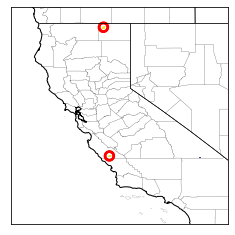

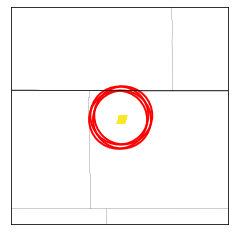

In [367]:
# FOR PLOTTING PURPOSES
FM[FM >= 31] = np.nan
#FM[FM == 40] = np.nan
#FM[FM == 50] = np.nan
#FM[FM == 60] = np.nan
FM[FM == -99] = np.nan
#FM[FM == 40] = np.nan
#FM[FM == 50] = np.nan
#FM[FM == 60] = np.nan
#FM[FM == 150] = np.nan
#FM[FM != 13] = np.nan
#FM[FM == max(FM[0])] = np.nan
#FM[FM == min(FM[0])] = np.nan
#
l = {'latitude': 37.75,
      'longitude': -120.5}
#
m = Basemap(resolution='i', projection='cyl', area_thresh=50000, llcrnrlon=l['longitude'] - 5,
             llcrnrlat=l['latitude'] - 5,
             urcrnrlon=l['longitude'] + 5, urcrnrlat=l['latitude'] + 5, )

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawcounties()

plt.figure(1, figsize=[150, 120])

# In order to plot, you must do pcolormesh, not imshow. If you do imshow, the image will be stretched (no idea why).
m.pcolormesh(lons,lats,FM, latlon=True)

if ca_fire_pts:
    x2, y2 = m([i[0] for i in ca_fire_pts], [i[1] for i in ca_fire_pts])
# PLACE CIRCLE AROUND A VALID PIXEL 
for x2, y2 in zip(x2,y2):
    fire_circle = Circle(xy=m(x2, y2), radius=0.2, fill=False, color='r', linewidth=2)
    plt.gca().add_patch(fire_circle)
print(f"Total Points: {len(ca_fire_pts)}")
plt.show()

l = {'latitude': 41.826,
      'longitude': -121.244}

m2 = Basemap(resolution='i', projection='cyl', area_thresh=50000, llcrnrlon=l['longitude'] - 0.75,
             llcrnrlat=l['latitude'] - 0.75,
             urcrnrlon=l['longitude'] + 0.75, urcrnrlat=l['latitude'] + 0.75, )
if ca_fire_pts:
    x2, y2 = m2([i[0] for i in ca_fire_pts], [i[1] for i in ca_fire_pts])
# PLACE CIRCLE AROUND A VALID PIXEL 
for x2, y2 in zip(x2,y2):
    fire_circle = Circle(xy=m(x2, y2), radius=0.2, fill=False, color='r', linewidth=2)
    plt.gca().add_patch(fire_circle)

# In order to plot, you must do pcolormesh, not imshow. If you do imshow, the image will be stretched (no idea why).
m2.pcolormesh(lons,lats,FM, latlon=True)
m2.drawcounties()
m2.drawstates()
plt.show()


As shown in this example, there may be several lat/lng points that are all a part of a single fire complex. This
presents a challenge when alerting users. Recall the program sends an alert when: 
<ol>
    <li>A new fire is detected within a specified distance to user's location.</li>
    <li>A fire already alerted to the user is spreading / growing rapidly toward the user's location. </li>
</ol>

Therefore, consider the simplified case below with 2 fire groups that are within the alert distance to the user.<br>
<b>Fire group 1 NO ALERT:</b> The user has already been alerted to this fire (not new), and the fire is not spreading.
<br>
<b>Fire group 2 ALERT:</b> This is a new fire and the user needs to be alerted. 

<b> Note: The grid spacing on the GOES-R is ~1km, this image is not to scale and is an oversimplification. 

![Fire Group Example](files/fire_pixels_ex.png)

<br>
Now consider a (probably rare) case where a new hotspot is detected between the two fire complexes. 

![Fire Group Example](files/fire_pixels_ex2.png)

In this case, the new point is actually close enough to both fires such that the grouping algorithm will
combine the fires, assigning the fire ID number to 1 (the minimum of all the fire IDs in the complex). The user
would be alerted due to the fact that the size of the fire increased significantly in size 
(this could / should be changed?).

![Fire Group Example](files/fire_pixels_ex3.png)

The following code shows how the grouping algorithm accomplishes this:


In [368]:
# Turn the current fire hotspot locations into a dict. 
fire_pts = [{"lat": ll[1], "lng":ll[0], "fire_id": nan, "scan_dt": fdfc_DATE, "s3_filename":FILE} for ll in ca_fire_pts]

# If any hotspot is a new fire, we'll have to assign it a new ID. The ID just needs to be unique, so we'll 
# accomplish this by extracting the max ID that is currently in our database. 
CURSOR.execute("SELECT max(fire_id) FROM goes_r_fire WHERE fire_id IS NOT NULL")
idNum = CURSOR.fetchone()[0]
if not idNum: 
    max_group_id = 0
else: 
    max_group_id = maximum(idNum, 0) + 1
fire_group_num = max_group_id
print(max_group_id)

5.0


We need to examine the entire database of active fire points to check if any new fire points are 
a part of an existing complex, or if they are an entirely new complex.   


In [369]:
# Get every lat/lng point that exists in the database
sql = "SELECT lng, lat, fire_id, scan_dt, s3_filename, cal_fire_incident_id FROM goes_r_fire"
CURSOR.execute(sql)
db_resp = CURSOR.fetchall()

# Get only the last two elements (i.e. drop the id and kep latlng)
# "set" is a fantastic function that will turn this into an unordered/unindexed dict of tuples.
# So if you do something like: thisset = {"apple", "banana", "cherry"}, then print("banana" in set) -> True
db_latlngs = set([resp[:2] for resp in db_resp])

# We need to create a dict in order to compare what's in the database to our current GOES-R fire pts
db_fire_pts = [{"lat": dbll[1],
                "lng": dbll[0],
                "fire_id": dbll[2],
                "scan_dt": dbll[3],
                "s3_filename": dbll[4],
                "cal_fire_incident_id": dbll[5],
                } for dbll in db_resp]

# Only accept points that don't exist in the database yet.
new_fire_pts = [pt for pt in fire_pts if (pt["lng"], pt["lat"]) not in db_latlngs]

# Extend any new points to the end of the array containing the all the current points.
db_fire_pts.extend(new_fire_pts)
print(f"NEW FIRE POINTS TO CHECK: {new_fire_pts}")


NEW FIRE POINTS TO CHECK: []


In [370]:

# The following loops: Check each valid fire pixel and determine if it has an ID associated with it. If not,
#                      assign it a new ID based on its proximity to any other valid fire pixels.
#
# Assigning a new ID to a fire pixel is done by:
# 1) If this new point doesn't have an id, we will loop through all the fire pixels to see if it's
#    a) part of an existing fire (i.e. close enough to another pixel that has an ID already)
#    b) a new fire (i.e. a pixel that is to far away to any other active fire, so a new ID will be given).
# 2) If this pixel already has an ID, the loop will see if there are any additional points that may
#   have been missed (e.g. this new point could be on the opposite edge of the fire, which may put it close
#   enough to other grid boxes that the first point missed).

for row in db_fire_pts:
    row_point = Point(row["lng"], row["lat"])
    for pt in db_fire_pts:
        pt_coords = Point(pt["lng"], pt["lat"])
        
        # To find the distnace in meters, we need to solicit pyproj
        geod = Geod(ellps='WGS84')

        angle1, angle2, dist = geod.inv(row_point.x, row_point.y, pt_coords.x, pt_coords.y)
        if dist < xres * 10:
            # These two points are close enough to be considered the same fire. So we are checking two things:
            # 1) This point in the database already has an ID
            #    a) Always use the lowest, non-null, group number. This ensures that if a point that develops
            #       between two fires, this new point would link the two fires together. This only works
            #       because we're looping from ID #1 to ID #n; therefore, if this is a point that links two
            #       fires it would first link fire_id = x, then link fire_id = x+n, but both fires would be
            #       assigned fire_id = x

            row["fire_id"] = np.nanmin([pt["fire_id"], row["fire_id"]])
            
            # If row["fire_id"] is still nan, then both of these points are none and we need to assign an ID
            if np.isnan(row["fire_id"]):
                row["fire_id"] = fire_group_num
                pt["fire_id"] = fire_group_num
                fire_group_num += 1

        # The points were too far apart to be considered a fire, but double check to make sure the point in the
        # database actually has an id (could probably leave this code out, but its a failsafe).
        if np.isnan(pt["fire_id"]):
                pt["fire_id"] = fire_group_num
                fire_group_num += 1

    # Finally, if the row we're checking still does not have an ID at this time, then it means it is not close
    # enough to any other point and it needs to be assigned an new ID.
    if np.isnan(row["fire_id"]):
        row["fire_id"] = fire_group_num
        fire_group_num += 1

# Now that we have grouped our fire points into fires, we want to see if CAL Fire has already
# declared any of these as active fires. The idea here is to download their fire data via csv (no api as of yet),
# and test whether any of the points detected on the GOES-R are associated with a fire already identified by CAL
# fire. If so, our fire points will now be given that fire ID, which will act the foreign key to each sql table.
# So, first we have to check if any of our fires are within a certain range of all the fires listed. If not,
# then CAL fire has not identified the fire and we will assign our own id to the points.

df = pd.DataFrame(db_fire_pts)
df["cal_fire_incident_id"] = np.nan
df_calfire = pd.DataFrame()
try:
    df_calfire = pd.read_csv("https://www.fire.ca.gov/imapdata/mapdataactive.csv")
    df_calfire.to_sql("cal_fire", CONN, if_exists='replace', index=False)
    df_calfire.drop(df_calfire[df_calfire.is_active == 'N'].index, inplace=True)
except:
    print("Could Not download CALFIRE csv")

if not df_calfire.empty and not df.empty:
    # Store Cal Fire's incident lat lng points as a list of shapely POINT objects
    cf_pts = [Point(lng, lat) for lng, lat in zip (df_calfire["incident_longitude"], df_calfire["incident_latitude"])]

    # Shapely has a function that will calculate closest point to a list of points. For every valid fire point in
    # our grid, we will store the nearest point. This returns a list of tuples where
    # tuple[0] = reference point (in lng lat) and tuple[1] = nearest point to our ref point.
    nearest = [shapely.ops.nearest_points(Point(lng,lat), MultiPoint(cf_pts))
               for lng, lat in zip(df['lng'],df['lat'])]

    for pt in nearest:
        # Return the row (index number) of the dataframe for the point we're examining.
        df_row = df.loc[df["lat"] == pt[0].y].index[0]

        # x != x will be true if x is nan. So if we don't have a Cal Fire ID for this row, check to see if
        # there is a Cal Fire close to our point.
        if df.iloc[df_row]["cal_fire_incident_id"] != df.iloc[df_row]["cal_fire_incident_id"]:
            raster_pt = pt[0]
            closest_cal_fire = pt[1]
            #distance = raster_pt.distance(closest_cal_fire)

            # To find the distnace in meters, we need to solicit pyproj
            geod = Geod(ellps='WGS84')
            angle1, angle2, distance = geod.inv(raster_pt.x, raster_pt.y, closest_cal_fire.x, closest_cal_fire.y)
            if distance < xres*20:
                # Get the row (index number) of the dataframe for the point we're examining.
                df_row = df.loc[df["lat"] == pt[0].y].index[0]

                # Get the row of calfire dataframe.
                df_calfire_row = df_calfire.loc[df_calfire["incident_latitude"] == pt[1].y].index[0]


                this_fireID = df.iloc[df_row]['fire_id']

                # Change the cal_fire_incident_id number in the df to the same as in the df_calfire
                df.loc[df.fire_id == this_fireID, "cal_fire_incident_id"] = df_calfire.loc[df_calfire_row]["incident_id"]
df.to_sql('goes_r_fire', CONN, index=False, if_exists='replace')
print(df[['lat','lng','fire_id']])


         lat         lng  fire_id
0  41.826469 -121.244614      0.0
1  41.827389 -121.217571      0.0
2  41.797681 -121.252915      0.0
3  41.798599 -121.225887      0.0
4  35.905911 -120.969689      4.0
5  35.906646 -120.945082      4.0
6  35.880578 -120.975793      4.0
7  35.881311 -120.951196      4.0


<b> If the dataframe has any <code>fire_id's</code> without an assigned value, then we have a problem. 

If not, it's time to check whether or not the user needs to be updated. 


In [371]:
loop_duration = 1
past_hour = datetime.utcnow() - timedelta(hours=loop_duration)

# List of all GOES detected hotspots in the last hour.
sql = "SELECT lng, lat, fire_id FROM goes_r_fire WHERE scan_dt >= ?"
CURSOR.execute(sql, [past_hour])
respGoesF = list(CURSOR.fetchall())

# List of all the active CAL FIRE incidents.
sql = "SELECT incident_longitude, incident_latitude, incident_id FROM cal_fire WHERE is_active == 'Y'"
CURSOR.execute(sql)

# LatLng list of every active CalFire incident.
calfirell = list(CURSOR.fetchall())

# Get the coordinates of the user you're interested in alerting.
sql = "SELECT user_lng, user_lat, user_id FROM users WHERE user_id == ?"
CURSOR.execute(sql, ['1'])
respUsers = list(CURSOR.fetchall())

# Latlng of user turned into Point cords
userll = Point(respUsers[0][:-1])

print(userll)


POINT (-109.5 38.5)


At this point in the program, we now have all the data in the database for 
fires detected by the GOES-R and fired detected by CalFire. 

The process at this point now becomes fairly straightforward. 
<ul>
<li>Look for any hotspots in the GOES-R and CalFire Database tables that have been recorded in the last hour</li>
<li>If any new points have been recorded <b>and</b> the points are close enough to the user <b>and</b> the
user hasn't been alerted to this ID yet, then:
<ul>
    <li><b>alert the user.</b> </li>
    <li><b>update the database to reflect the fact that the user has now been alerted to this fire_id</b></li>
</ul>
</li>
</ul>

The GOES-R fire hotspot detection database would now look something like this with ID's assigned
to the various hotspot pixels:

![GOES DB Example](files/goes_r_fire_db.png)


In [372]:

# User ID number
userID = respUsers[0][2]

# Test if GOES detected any hotspots within range of user
for pt in respGoesF:
    ll = Point(pt[:-1])  # Lat lng of point
    fire_id = pt[2]  # ID given to fire

    geod = Geod(ellps='WGS84')
    angle1, angle2, dist = geod.inv(ll.x, ll.y, userll.x, userll.y)  # Distance of user to fire

    sql = "SELECT need_to_alert FROM user_alert_log WHERE user_id = ? AND alerted_incident_id = ?"  # Check user has been alerted to this ID
    CURSOR.execute(sql, [userID, fire_id])
    already_alerted = CURSOR.fetchone()  # This will be None if not alerted yet.

    # If dist is < 1000 km add this point to the user_alert_log and set need_to_alert value to True
    if dist < (1000 * 1000) and not already_alerted:
        sql = '''INSERT INTO user_alert_log 
                    (user_id, alerted_incident_id, alert_time, need_to_alert, dist_to_fire, fire_lng, fire_lat) 
                    VALUES (?, ?, ?, ?, ?, ?, ?)'''
        CURSOR.execute(sql, [userID, fire_id,
                             datetime.now().strftime('%Y-%m-%d %H:%M:%S'), True, int(dist*0.00062),
                             pt[0], pt[1]])
        CONN.commit()
        print(f"Need to alert user on GOES detected fire located at lat/lng {pt[1]}/{pt[0]}")


In [373]:
# Test if GOES detected any hotspots within range of user
for pt in calfirell:
    ll = Point(pt[:-1])  # Latlng of Cal Fire point
    cfID = pt[2]  # The incident ID of the fire (given by CalFire)

    # Check user has been alerted to this ID# The incident ID of the fire (given by CalFire)
    sql = "SELECT need_to_alert FROM user_alert_log " \
          "WHERE user_id = ? AND alerted_cal_fire_incident_id = ?"
    CURSOR.execute(sql, [userID, cfID])
    already_alerted = CURSOR.fetchone()  # This will be None if not alerted to this ID yet

    # Distance
    geod = Geod(ellps='WGS84')
    angle1, angle2, dist = geod.inv(ll.x, ll.y, userll.x, userll.y)
    if dist < 100000000 and not already_alerted:
        sql = '''INSERT INTO user_alert_log 
                    (user_id, alerted_cal_fire_incident_id, alert_time, 
                    need_to_alert, dist_to_fire, fire_lng, fire_lat) 
                    VALUES (?, ?, ?, ?, ?, ?, ?)'''
        CURSOR.execute(sql, [int(userID), cfID,
                             datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                             True, int(dist*0.00062), pt[0], pt[1]])
        CONN.commit()
        print(f"Need to alert user on CAL FIRE located at lat/lng {pt[1]}/{pt[0]}")

# Check if any values for this user need to be alerted
sql_alert_count = "SELECT COUNT(*) FROM user_alert_log WHERE user_id=? AND need_to_alert=1"
CURSOR.execute(sql_alert_count, [userID])
alert_num = list(CURSOR.fetchone())[0]
print(f"There are a total of {alert_num} fires the user must be alerted to.")


There are a total of 8 fires the user must be alerted to.



The user alert database would now look something like this, where there is one fire that is located
14 miles away from the user and the user has not been alerted yet (need_to_alert=1):

![User Alert DB Example](files/db_user_alert_ex.png)


New Fire Detected, Setting up alert...
Download Successful C:\Users\smotley\AppData\Local\Temp\tmprx040hy5
DATE OF FDFC FILE: 2019-07-29 23:55:07
DATE OF MULTIBAND FILE: 2019-07-29 22:02:39
MINUTES BETWEEN FILES:112.46666666666667


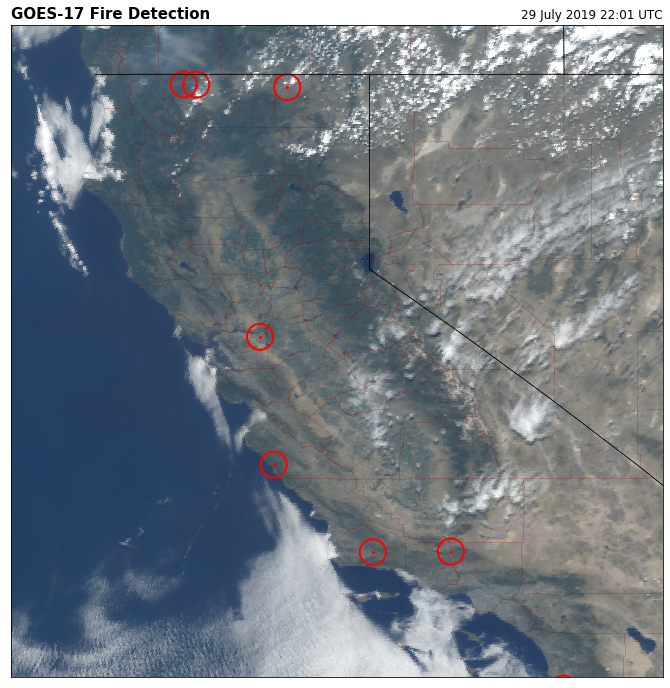

Download Successful C:\Users\smotley\AppData\Local\Temp\tmpd6mi0ycm
DATE OF FDFC FILE: 2019-07-29 23:55:07
DATE OF MULTIBAND FILE: 2019-07-29 22:07:39
MINUTES BETWEEN FILES:107.46666666666667


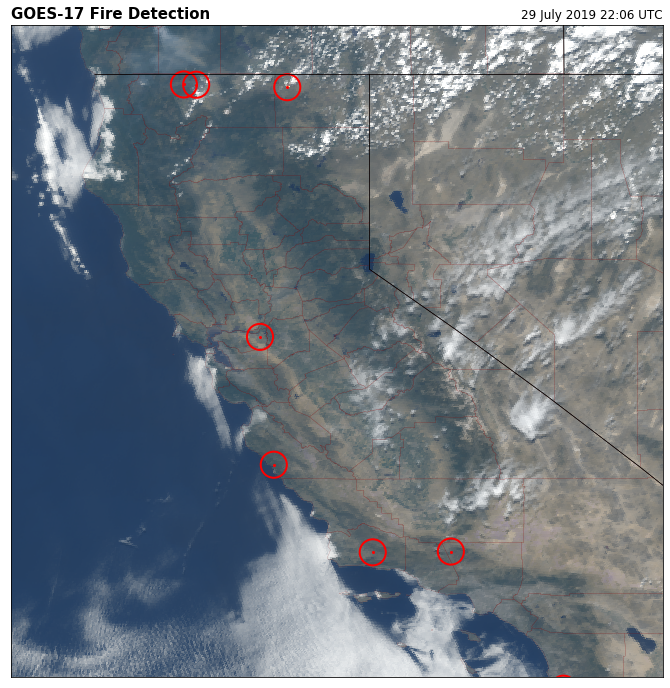

Download Successful C:\Users\smotley\AppData\Local\Temp\tmpjdnlsc1o
DATE OF FDFC FILE: 2019-07-29 23:55:07
DATE OF MULTIBAND FILE: 2019-07-29 22:12:38
MINUTES BETWEEN FILES:102.48333333333333


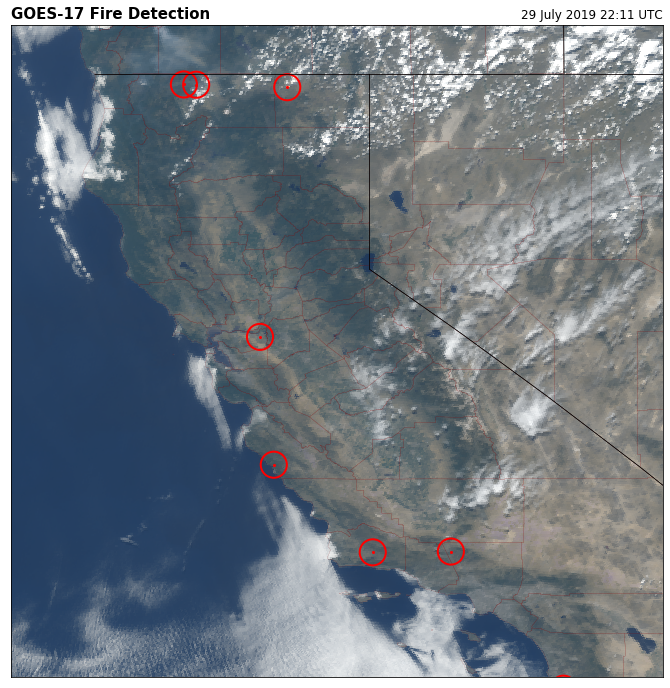

Can't open file: C:\Users\smotley\AppData\Local\Temp\tmp39l7fs8t


AttributeError: 'NoneType' object has no attribute 'variables'

In [374]:
if alert_num > 0:
    print("New Fire Detected, Setting up alert...")
    
    # A list of files already downloaded into the database and processed into .png images.
    CURSOR.execute("SELECT s3_filename FROM goes_r_images")
    already_downloaded = [item[0] for item in list(CURSOR.fetchall())]

    # To create an mp4 loop that is "hours_of_data" in length, we first need to get all the file names
    # of the multiband files.
    mp4_files = AwsGOES(
            bands=[7,8],
            bucket=bucket,
            st_dt=fdfc_DATE.strftime("%m/%d/%Y %H:%M"),
            hrs=hours_of_data).bucket_files

    sql = '''SELECT fire_lng, fire_lat FROM user_alert_log WHERE user_id = 1 AND need_to_alert = 1'''
    CURSOR.execute(sql)
    map_lnglat = [item for item in list(CURSOR.fetchall())]

    # If the file isn't in our database yet, go download it.
    for mp4_file in (mp4_file for mp4_file in mp4_files if mp4_file not in already_downloaded):
        # Download multiband netcdf file
        C = goes_multiband.download_file(mp4_file, goes_multiband.bucket, s3)     # NETCDF File containing multiband GOES data

        # Seconds since 2000-01-01 12:00:00
        add_seconds = int(np.ma.round(C.variables['t'][0], decimals=0))
        DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

        # Timestamp difference between the GOES multiban scan and the GOES Fire detection scan. This should be < 6 min.
        scan_diff = abs(fdfc_DATE - DATE).seconds / 60

        print(f"DATE OF FDFC FILE: {fdfc_DATE}\n"
              f"DATE OF MULTIBAND FILE: {DATE}\n"
              f"MINUTES BETWEEN FILES:{scan_diff}")

        if scan_diff > 1:
            logging.info("Duration between GOES mutiband and GOES Hotspot detection scan is " +
                                   str(scan_diff) + " minutes.")

        # Create a true color image and store the png file in the database.
        composite_img = Fire_Image(C=C, fileName=FILE).Composite

        # Scan's start time, converted to datetime object
        scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')
        
        scan_mid = int(np.ma.round(C.variables['t'][0], decimals=0))
        DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=scan_mid)
        
        # Satellite height
        sat_h = C.variables['goes_imager_projection'].perspective_point_height
        
        # Satellite longitude
        sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
        
        # Satellite sweep
        sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis
        
        # The projection x and y coordinates equals the scanning angle (in radians) multiplied by
        # the satellite height (https://proj.org/operations/projections/geos.html)
        x = C.variables['x'][:] * sat_h
        y = C.variables['y'][:] * sat_h
        
        # map object with pyproj
        p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
        
        # to latitude and longitude values.
        XX, YY = np.meshgrid(x, y)
        lons, lats = p(XX, YY, inverse=True)
        
        # Location of California
        l = {'latitude': 37.75,
             'longitude': -120.5}
        
        # Draw zoomed map
        m = Basemap(resolution='i', projection='cyl', area_thresh=50000, llcrnrlon=l['longitude'] - 5,
                    llcrnrlat=l['latitude'] - 5,
                    urcrnrlon=l['longitude'] + 5, urcrnrlat=l['latitude'] + 5, )
        
        # We need an array the shape of the data, so use R. The color of each pixel will be set by color=colorTuple.
        #newmap = m.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
        #newmap.set_array(None)  # Without this line the RGB colorTuple is ignored and only R is plotted.
        
        plt.figure(figsize=[15, 12])
        
        newmap = m.pcolormesh(lons, lats, composite_img['R'], color=composite_img['rgb_tuple'], linewidth=0, latlon=True)
        newmap.set_array(None)
        
        plt.title('GOES-17 Fire Detection', loc='left', fontweight='semibold', fontsize=15)
        plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC'), loc='right');
        
        m.drawcountries()
        m.drawstates()
        m.drawcounties(color='darkred')
        
        
        x2, y2 = m([i[0] for i in map_lnglat], [i[1] for i in map_lnglat])
        # PLACE RED DOT ON CENTER POINT OF OF VALID PIXEL
        m.plot(x2, y2, 'ro', markersize=2)
        for x2, y2 in zip(x2,y2):
            fire_circle = Circle(xy=m(x2, y2), radius=0.2, fill=False, color='r', linewidth=2)
            plt.gca().add_patch(fire_circle)
        
        curDir = os.path.dirname(os.getcwd())
        imgDir = os.path.join(curDir, 'processed_images')
        imgFile = DATE.strftime('%d_%B_%Y_%H%M') + '.png'
        buf = io.BytesIO()
        plt.savefig(buf, bbox_inches='tight', format='png')
        buf.seek(0)
        plt.show()
        
        
        # Store image into database
        ablob = buf.getvalue()
        sql = '''INSERT INTO goes_r_images (fire_temp_image, scan_dt, s3_filename) VALUES (?, ?, ?)'''
        CONN.execute(sql, [ablob, DATE, FILE])
        CONN.commit()
        buf.close()

In [ ]:
if alert_num > 0:
    frames = []
    cursor = CONN.cursor()
    one_hour = fdfc_DATE - timedelta(hours=1)
    sql = "SELECT scan_dt FROM goes_r_images WHERE scan_dt <= ? AND scan_dt >= ?"
    cursor.execute(sql, [fdfc_DATE, one_hour])
    timestamps = list(cursor.fetchall())
    for imgtime in timestamps:
        sql = "SELECT fire_temp_image FROM goes_r_images WHERE scan_dt = ?"
        cursor.execute(sql, imgtime)
        imgFile = cursor.fetchone()
        img = Image.open(io.BytesIO(imgFile[0]))
        frames.append(img)
    try:
        imageio.mimwrite('fire_cur.mp4', frames, fps=5)
    except:
        print("NO IMAGES TO PROCESS.")
    with open('fire_cur.mp4', 'rb') as gif:
        ablob = gif.read()
        sql = '''UPDATE goes_r_images SET fire_temp_gif = ? WHERE scan_dt = ?'''
        cursor.execute(sql, [sqlite3.Binary(ablob), timestamps[-1][0]])
        CONN.commit()
print("COMPLETE!")
CONN.close()


If we had used the for loop above, we would have a video with more than one frame. 
<div align="left">
<video src="fire_jupyter.mp4" type="video/mp4" width="30%" controls></video></div>